In [1]:
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../peptidome.mplstyle')

import evcouplings.align, evcouplings.couplings

import sys
sys.path.append('..')
from lib import *
from lib import maxent

In [2]:
k = 4
q = len(aminoacids)

In [3]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]

In [4]:
train, test = train_test_split(humanseqs, test_size=0.5)

In [5]:
empirical_kmers = [string[i:i+k] for string in train for i in range(len(string)-k+1) if isvalidaa(string[i:i+k])]

In [6]:
seqmat = np.array([list(kmer) for kmer in empirical_kmers])

In [7]:
map_ = map_ = {c: i for i, c in enumerate(aminoacids)}
mapped_seqmat = evcouplings.align.map_matrix(seqmat, map_)

In [8]:
fi = evcouplings.align.frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids))

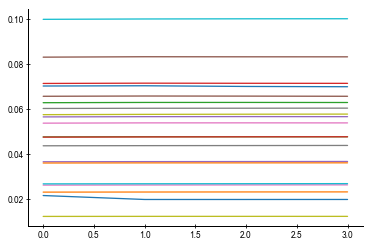

In [9]:
plt.plot(fi);

In [10]:
fij = evcouplings.align.pair_frequencies(mapped_seqmat, np.ones(len(seqmat)), num_symbols=len(aminoacids), fi=fi)

In [11]:
cij = evcouplings.couplings.compute_covariance_matrix(fi, fij)

In [12]:
cij.shape

(76, 76)

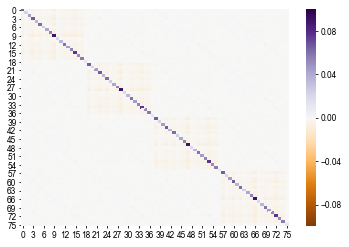

In [13]:
sns.heatmap(cij, vmin=-0.1, vmax=0.1, cmap='PuOr')

In [14]:
invC = np.linalg.inv(cij)

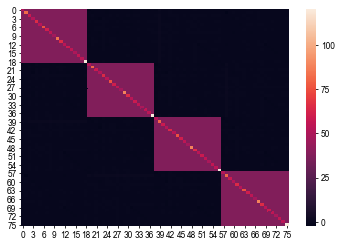

In [15]:
sns.heatmap(invC)

In [16]:
q = len(aminoacids)
N = k
cij.shape, N*(q-1)

((76, 76), 76)

In [17]:
C = cij.copy()
D = np.diag(np.diagonal(cij))
A = C.copy()
A[np.diag_indices_from(A)] = 0.0

In [18]:
np.diagonal(cij).min(), A.max()

(0.01196938119559453, 0.002982074930161451)

In [19]:
Dinv = np.diag(1/np.diagonal(cij))
A = cij.copy()
A[np.diag_indices_from(A)] = 0.0
invCapprox = Dinv-Dinv@A@Dinv

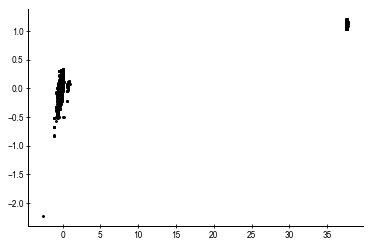

In [20]:
mask = ~np.eye(invC.shape[0],dtype=bool)
plt.plot(invC[mask].flatten(), invCapprox[mask].flatten(), 'k.')

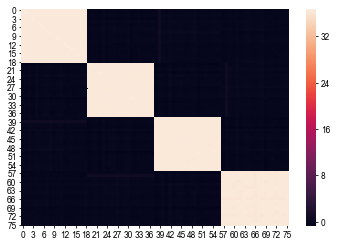

In [21]:
sns.heatmap(invC-invCapprox)

In [22]:
def JijfrominvC(invC):
    Jij = evcouplings.couplings.reshape_invC_to_4d(invC, seqmat.shape[1], len(aminoacids))
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

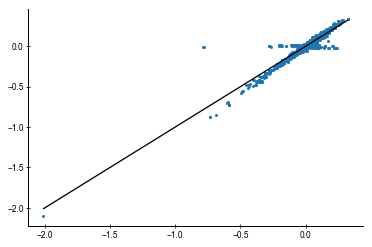

In [23]:
Jij_zerogauge = JijfrominvC(invC)
Jij_zerogauge_approx = JijfrominvC(invCapprox)
plt.plot(Jij_zerogauge.flatten(), Jij_zerogauge_approx.flatten(), '.')
x = np.linspace(min(Jij_zerogauge.flatten()), max(Jij_zerogauge.flatten()))
plt.plot(x, x, 'k')

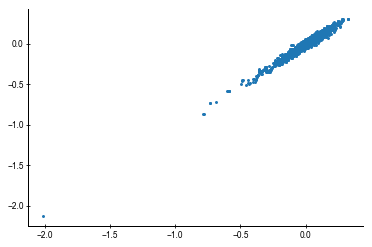

In [24]:
rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(Jij_zerogauge[mask].flatten(), -rhoij[mask].flatten(), '.')

In [25]:
Jij_corr = -rhoij
Jij_zerogauge_corr = evcouplings.couplings.model._zero_sum_gauge(Jij_corr)

In [26]:
hi = evcouplings.couplings.fields(Jij_zerogauge, fi)
print(hi)

#for i in range(hi.shape[0]):
#    for a in range(hi.shape[1]):
#        hi[i, a] += np.sum(Jij[i, :, a, :])

[[ 0.89752269 -0.07281932  0.58232387  0.93548344  0.36732537  0.87021794
   0.01471589  0.53722642  0.76484283  1.29562027 -0.2191712   0.3288629
   0.77948882  0.55312893  0.73763077  1.08276793  0.67396597  0.81351711
  -0.72518618  0.08618009]
 [ 0.88676034 -0.11539266  0.57989394  0.92885253  0.36789733  0.87097104
   0.0157558   0.54564175  0.77961963  1.29668317 -0.28425886  0.3405876
   0.76150369  0.55258767  0.74558946  1.08921996  0.68329167  0.80825549
  -0.72641106  0.09296561]
 [ 0.87748452 -0.08881751  0.57791746  0.93020174  0.35761     0.85947842
   0.02370312  0.5371459   0.77849383  1.29444809 -0.28944578  0.34481987
   0.76633545  0.56138609  0.74716838  1.0899552   0.6877514   0.80782562
  -0.72887105  0.06493039]
 [ 0.87909548 -0.04198681  0.57624625  0.92331099  0.35083295  0.85984981
   0.00389778  0.52282629  0.7670217   1.3024009  -0.27931894  0.34848666
   0.78222357  0.55458928  0.73347018  1.08513932  0.68127697  0.80689981
  -0.73302811  0.05557514]]


In [27]:
N = k
q = 20
cij_flat = cij.reshape(N, q-1, N, q-1)

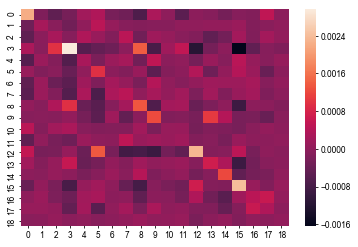

In [28]:
sns.heatmap(cij_flat[0, :, 1, :])

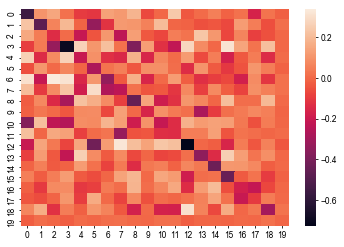

In [29]:
sns.heatmap(Jij_zerogauge_approx[0, 1])

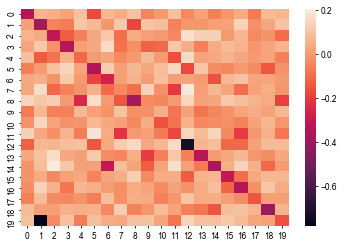

In [30]:
sns.heatmap(Jij_zerogauge[0, 2])

In [31]:
import numba
@numba.jit(nopython=True)
def energy_potts(x, hi, Jij):
    e = 0
    for i in range(len(x)):
        e += hi[i, x[i]]
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            e += Jij[i, j, x[i], x[j]]
    return -e

In [32]:
jump = lambda x: np.random.randint(q, size=k)
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_potts(x, hi, -Jij_zerogauge), jump, 1e6)

In [33]:
fi_model = evcouplings.align.frequencies(samples, np.ones(len(samples)), num_symbols=q)
fij_model = evcouplings.align.pair_frequencies(samples, np.ones(len(samples)), num_symbols=q, fi=fi_model)
cij_model = evcouplings.couplings.compute_covariance_matrix(fi_model, fij_model).flatten()

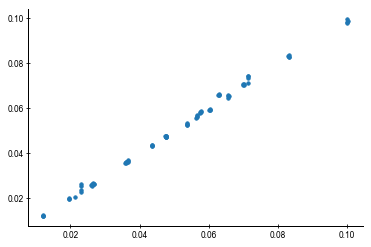

In [34]:
plt.plot(fi.flatten(), fi_model.flatten(), 'o')

(-0.01, 0.01)

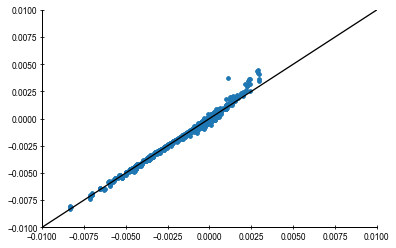

In [35]:
plt.plot(cij.flatten(), cij_model.flatten(), 'o')
x = [-0.01, 0.01]
plt.plot(x, x, 'k')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)

In [36]:
kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df = pd.DataFrame.from_dict(dict(seq=kmers, freq=np.zeros(len(kmers))))
df.set_index('seq', inplace=True)
df['freq'] = df['freq'].add(maxent.count(train, k)['freq'], fill_value=0.0)
df['freq_test'] = np.zeros(len(kmers))
df['freq_test'] = df['freq_test'].add(maxent.count(test, k)['freq'], fill_value=0.0)

In [38]:
df['freq_maxent'] = np.exp([-energy_potts(evcouplings.align.map_matrix(list(s), map_), hi, -Jij_zerogauge) for s in kmers])
df['freq_maxent'] /= np.sum(df['freq_maxent'])
jsd_maxent = calc_jsd(df['freq_test'], df['freq_maxent'], base=2)
jsd_maxent, scipy.stats.entropy(df['freq_maxent'], base=2)

(0.01468193683722711, 16.6121511830779)

In [39]:
Sind = sum([scipy.stats.entropy(fi[i], base=2) for i in range(fi.shape[0])])
Itot = 0.0
for i in range(fij.shape[0]):
    for j in range(i+1, fij.shape[0]):
        I = np.sum(fij[i, j]*np.log2(fij[i, j]/np.outer(fi[i], fi[j])))
        print(i, j, I)
        Itot += I
Sind, Itot, Sind-Itot

0 1 0.013772404691858177
0 2 0.009740576343510084
0 3 0.010410108709941416
1 2 0.01370965677736796
1 3 0.009771762985039182
2 3 0.013689177643913818


(16.701907472487587, 0.07109368715163064, 16.630813785335956)

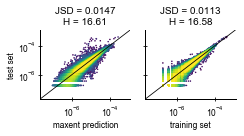

In [45]:
scatter = lambda x, y, ax: plotting.density_scatter(x, y, ax=ax, s=0.5, bins=100,
                                           trans=lambda x: np.log(x+1e-8),
                                           norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=50 if k ==3 else 400),
                                           cmap='viridis')
#scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)

fig, axes = plt.subplots(figsize=(3.5, 2.0), ncols=2, sharex=True, sharey=True)
axes[0].set_ylabel('test set')

for ax, column, xlabel in [(axes[0], 'freq_maxent','maxent prediction'),
                           (axes[1], 'freq', 'training set')
                            ]:
    scatter(df[column], df['freq_test'], ax)
    ax.set_xlabel(xlabel)
    jsd = calc_jsd(df['freq_test'], df[column], base=2)
    entropy = scipy.stats.entropy(df[column], base=2)
    ax.set_title('JSD = {:.4f}\nH = {:.2f}'.format(jsd, entropy))
    
if k == 3:
    x = np.logspace(-5.7, -2.7)
elif k == 4:
    x = np.logspace(-7.7, -2.9)
for ax in axes:
    ax.plot(x, x, 'k', lw=0.8)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png' if k == 3 else 'comparison_k4.png', dpi=600)

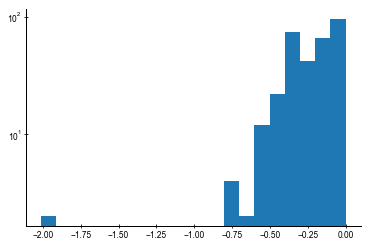

In [41]:
plt.hist(np.diagonal(Jij_zerogauge, axis1=2, axis2=3).flatten(), bins=20)
plt.yscale('log')

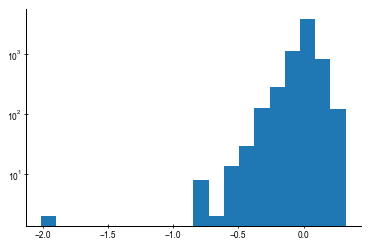

In [42]:
plt.hist(Jij_zerogauge.flatten(), bins=20)
plt.yscale('log')

In [43]:
sns.heatmap(pd.DataFrame(Jij_zerogauge[0, 4], index=list(aminoacids), columns=list(aminoacids)))#.reshape(N*q, N*q))

IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
alignment = evcouplings.align.Alignment(seqmat,
                                        sequence_ids=[str(i)+'/1-4' if i == 0 else '' for i in range(len(seqmat))],
                                        alphabet=evcouplings.align.ALPHABET_PROTEIN_NOGAP)

In [ ]:
mfdca = evcouplings.couplings.MeanFieldDCA(alignment)

In [ ]:
fit = mfdca.fit(pseudo_count=0.5)

In [ ]:
fit.J_ij.shape

In [ ]:
plt.imshow(evcouplings.couplings.model._zero_sum_gauge(fit.J_ij)[0, 1])
plt.colorbar()